# Module 2 project
*Laura Lewis, March 2019*

The goal of this project is to extract useful insights from the Northwind database. This is a sample database from Microsoft for a fictitious company called Northwind Traders, which imports and exports specialty foods from around the world. The database contains a range of information on the company's activities.

Four questions will be addressed in this project:

1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

2. Do discounts affect the amount that a customer spends on their order? If so, at what level(s) of discount, and does offering discounts make back more than they cost?

3. Does the average amount spent per order vary between customers from different regions?

4. Do customers order more products on particular days of the week?

***

## Question 1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

### Obtaining and scrubbing the data

In this section, the data required to answer the question will be imported using SQLAlchemy. Then the dataset will be cleaned so that exploratory analysis and statistical tests are able to be conducted in the following section.

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

The database schema is illustrated below. This was used to determine what data was required and how to extract it.

![title](Northwind_ERD.png)

In [2]:
# Creating an engine and connecting to a database with SQLAlchemy
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

2019-03-08 18:38:10,859 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-03-08 18:38:10,864 INFO sqlalchemy.engine.base.Engine ()
2019-03-08 18:38:10,866 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-03-08 18:38:10,867 INFO sqlalchemy.engine.base.Engine ()


In [76]:
# Getting the table names - which differ slightly from the schema
inspector = inspect(engine)
inspector.get_table_names()

2019-03-08 18:58:22,148 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-03-08 18:58:22,149 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In this query we want to extract the quantity of products ordered and the discount level for each part of each order, from the OrderDetail table.

In [4]:
# Extracting the dataset for question 1 as a pandas dataframe
df1 = pd.read_sql_query("""SELECT Quantity, Discount FROM OrderDetail""", engine)
df1.head()

2019-03-08 18:38:10,889 INFO sqlalchemy.engine.base.Engine SELECT Quantity, Discount
FROM OrderDetail
2019-03-08 18:38:10,890 INFO sqlalchemy.engine.base.Engine ()


,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [5]:
# Total number of rows in the dataset
len(df1)

2155

Inspecting the discount levels reveals that most fall into the categories of either no discount or 5%, 10%, 15%, 20% or 25% off:

In [6]:
df1.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

The remaining discount levels are all recorded as between 0.01 and 0.06, but the numbers of orders in each of these categories is so small that they should be combined into other groups for analysis. One option would be to include each of them in the nearest category, i.e. either 0.00 or 0.05. However, it is also possible that some of these are data entry issues, e.g. 0.01 could be 0.10 written incorrectly. Therefore these rows can be dropped as they make up a very small proportion of the dataset.

In [7]:
# Dropping all rows where the discount level is not 5%, 10%, 15%, 20% or 25%
df1 = df1[df1.Discount.isin(['0.00', '0.05', '0.10', '0.15', '0.20', '0.25'])]

The question refers to orders either with or without a discount. An additional column will be added to bin discount levels into orders where the discount is 0 (no discount) and orders with a discount greater than 0 (has a discount).

In [8]:
# Binning discount levels into 1 (discount) and 0 (no discount)
df1['Discount_bin'] = df1['Discount'].apply(lambda x: 1 if x > 0 else 0)

The database can now be inspected for any further necessary cleaning.

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2154
Data columns (total 3 columns):
Quantity        2147 non-null int64
Discount        2147 non-null float64
Discount_bin    2147 non-null int64
dtypes: float64(1), int64(2)
memory usage: 67.1 KB


There are no null values to replace.

### Exploring the data and answering the question

#### Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

To answer the first part of this question, a null and alternate hypothesis first need to be created:

**H<sub>0</sub>**: the average number of products ordered is the same with and without a discount

**H<sub>a</sub>**: the average number of products ordered with a discount is either higher or lower than orders without a discount

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

In [10]:
# Inspecting the summary statistics
df1.describe()

,Quantity,Discount,Discount_bin
count,2147.000000,2147.000000,2147.000000
mean,23.895203,0.056265,0.386586
std,19.009580,0.083586,0.487081
min,1.000000,0.000000,0.000000
25%,10.000000,0.000000,0.000000
50%,20.000000,0.000000,0.000000
75%,30.000000,0.100000,1.000000
max,130.000000,0.250000,1.000000


The graphs below show that the majority of items ordered have no discount, but the average number of items ordered with any level of discount is higher than for products with no discount (27 vs 22). This lends support to the alternate hypothesis that the number of items ordered is different for products with discounts vs. no discounts. However, there does not appear to be a consistently increasing trend in the number of items ordered as the discount level rises from 5% to 25%.

In [11]:
# Average number of items ordered with and without a discount
round(df1.groupby(['Discount_bin'])['Quantity'].mean(),0)

Discount_bin
0    22.0
1    27.0
Name: Quantity, dtype: float64

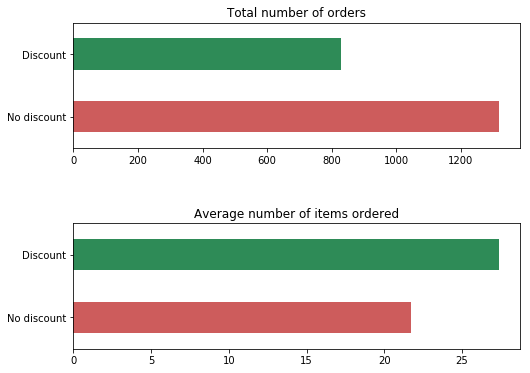

In [12]:
# Plotting the number of orders and average quantity of items ordered with and without discounts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df1.groupby(['Discount_bin'])['Quantity'].count().plot(kind='barh', ax=ax1, color=['indianred', 'seagreen'])
df1.groupby(['Discount_bin'])['Quantity'].mean().plot(kind='barh', ax=ax2, color=['indianred', 'seagreen'])
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax2.set_title('Average number of items ordered')
ax1.set_yticklabels(['No discount', 'Discount'])
ax2.set_yticklabels(['No discount', 'Discount'])
fig.subplots_adjust(hspace=0.6);

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


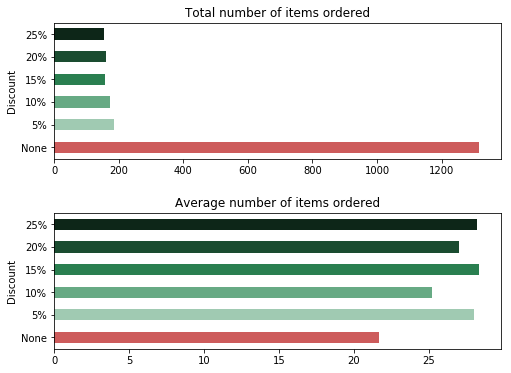

In [165]:
# Plotting the number of orders and average quantity of items ordered with different levels of discount
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df1.groupby(['Discount'])['Quantity'].count().plot(kind='barh', ax=ax1, colors=['indianred', '#A0CAB2', '#67AA84', '#2A7F50', '#1A4C30', '#0D2618'])
df1.groupby(['Discount'])['Quantity'].mean().plot(kind='barh', ax=ax2, colors=['indianred', '#A0CAB2', '#67AA84', '#2A7F50', '#1A4C30', '#0D2618'])
ax1.set_title('Total number of items ordered')
ax1.set_ylabel('Discount')
ax2.set_ylabel('Discount')
ax2.set_title('Average number of items ordered')
ax1.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
ax2.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
fig.subplots_adjust(hspace=0.4);

In order to properly answer this question, we must use statistical tests rather than just descriptive statistics. The correct hypothesis test needs to be chosen. In this case, a two-tailed t-test will be used. This is because the data is continuous, and because we are looking for either a decrease _or_ an increase in the number of products ordered.

A two-sample t-test assumes that the data is normally distributed, and that the samples have equal variances. This can be assessed with distribution plots:

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


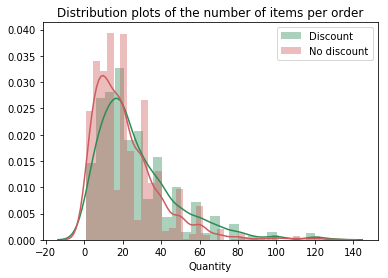

In [102]:
# Separating the dataset into orders with and without discounts, and assessing their distributions
discount = df1[df1['Discount_bin'] == 1]
no_discount = df1[df1['Discount_bin'] == 0]
sns.distplot(discount.Quantity, label='Discount', color='seagreen')
sns.distplot(no_discount.Quantity, label='No discount', color='indianred')
plt.title('Distribution plots of the number of items per order')
plt.legend();

The distribution plots above show that these assumptions hold true, although the distributions are positively skewed. A standard t-test can therefore be used (as opposed to a Welch's t-test).

In [15]:
# Running a two-sided t-test to compare two independent samples
stats.ttest_ind(discount.Quantity, no_discount.Quantity)

Ttest_indResult(statistic=6.7627297036707565, pvalue=1.7401995278127614e-11)

In [16]:
print("Average number of products ordered with no discounts: ", round(no_discount['Quantity'].mean(),1))
print("Average number of products ordered with discounts: ", round(discount['Quantity'].mean(),1))
print("Effect size: ", round(discount['Quantity'].mean() - no_discount['Quantity'].mean(),1))
print("Relative effect size (increase from no discount to discount): ", round((discount['Quantity'].mean() - no_discount['Quantity'].mean())/no_discount['Quantity'].mean(),2))

Average number of products ordered with no discounts:  21.7
Average number of products ordered with discounts:  27.4
Effect size:  5.6
Relative effect size (increase from no discount to discount):  0.26


The p-value is <0.001, which is less than the alpha value of 0.05. Therefore we can reject the null hypothesis and accept the alternative hypothesis. We can conclude that there is a statistically significant difference between the average number of items ordered with and without discounts.

 - **On average, 22 items are ordered for products without a discount, and 27 for items with a discount**

 - **Orders with discounts contain 6 more items on average than orders with no discounts, which is a 26% increase.**

**However, these correlations do not necessarily imply causation, and so it is not possible to categorically state that offering a discount will necessarily increase the order size by 26%.**

The second part of the question asks at what level of discount the statistically significant effect occurs. To answer this part of this question, a new null and alternate hypothesis need to be created:

**H<sub>0</sub>**: the average number of products ordered is the same at different levels of discount

**H<sub>a</sub>**: the average number of products ordered is different between the different levels of discount

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

To answer this question, ANOVA will be used in order to assess the degree of variation between multiple samples, where each sample is a different level of discount.

In [17]:
# Fitting a model of Total_Quantity on Discount categories, and using statsmodels to compute an ANOVA table
lm = ols('Quantity ~ C(Discount)', discount).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),1159.517551,4.0,0.674103,0.610041
Residual,354768.342690,825.0,NaN,NaN


In [18]:
# Summary of the model and its coefficients
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6741
Date:                Fri, 08 Mar 2019   Prob (F-statistic):              0.610
Time:                        18:38:12   Log-Likelihood:                -3691.7
No. Observations:                 830   AIC:                             7393.
Df Residuals:                     825   BIC:                             7417.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              28.0108      1.525     18.372      0.000      25.018      31.003
C(Discount)[T.0.1]     -2.7738      2.193     -1.265      0.206      -7.079       1.531
C(Discount)[T.0.15]     0.3714      2.250      0.165      0.869      -4.045       4.788
C(Discount)[T.0.2]     -0.9860      2.235     -0.441      0.659      -5.373       3.401
C(Discount)[T.0.25]     0.2294      2.262      0.101      0.919      -4.211       4.669
==============================================================================
Omnibus:                      263.705   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              751.622
Skew:                           1.598   Prob(JB):                    6.13e-164
Kurtosis:                       6.394   Cond. No.                         5.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The ANOVA table above reveals that the p-value is 0.610, which is much higher than the alpha value of 0.05. Therefore we cannot reject the null hypothesis that **there is no difference between the average number of items ordered between different discount levels**. The model summary table provides further evidence for this conclusion. The p-values for each pairwise comparison between the lowest level of discount (5%) and each other level of discount are all above the alpha value, indicating that no individual discount levels have a statistically significant effect. Additionally, the overall r/eta squared value for the model is negligible, confirming that **the different discount levels do not explain the differences in the numbers of items ordered in the different discount groups**.

### Conclusions

**Business insights:** 
 - There are statistically significant differences in the number of items ordered between products with no discounts and products with a discount.
 - The difference between the average number of items ordered for products with no discount (22) and those with a discount (27), i.e. a 26% increase.
 - However, there is no statistically significant effect from increasing the level of the discount.
 - A preliminary conclusion is that the impact of offering any discount at all (e.g. only 5%) on an order is greater than the impact of increasing the level of discount offered (a conclusion supported by the literature on behavioural economics).
 

**Potential business actions and directions for future work:**
 - Offering more low-value discounts (e.g. 5%) and reducing the number of higher-level discounts may have a beneficial effect on increasing the number of items that customers order overall.
 - However, additional analysis would be needed in order to provide further evidence that the differences in the number of items per order was due primarily to discount level rather than other factors (e.g. by ruling out the impacts of other features, such as different orders containing different types of products).

***

## Question 2: Do discounts affect the amount that a customer spends on their order? If so, at what level(s) of discount, and does offering discounts make back more than they cost?

The analysis above suggested that offering discounts encourages customers to buy more items. However, there is also a very tangible cost to giving customers discounts. Therefore it is also worth investigating whether offering discounts also increases the average cost per order (because people are buying additional discounted products that they wouldn't have bought otherwise), or decreases the average cost per order (because people are buying a greater number of cheaper discounted products, but because of the discounts there is no net benefit to the company's bottom line).

### Obtaining and scrubbing the data

In this query, we want to extract for each order the number of each product ordered, the unit price and the discount level (for calculating the actual price paid), from the OrderDetail table.

In [255]:
# Extracting the dataset for question 2 as a pandas dataframe
df2 = pd.read_sql_query("""SELECT OrderId, Quantity, UnitPrice, Discount
FROM OrderDetail""", engine)
df2.head()

2019-03-08 22:22:13,659 INFO sqlalchemy.engine.base.Engine SELECT OrderId, Quantity, UnitPrice, Discount
FROM OrderDetail
2019-03-08 22:22:13,660 INFO sqlalchemy.engine.base.Engine ()


,OrderId,Quantity,UnitPrice,Discount
0,10248,12,14.0,0.0
1,10248,10,9.8,0.0
2,10248,5,34.8,0.0
3,10249,9,18.6,0.0
4,10249,40,42.4,0.0


In [256]:
# Total number of rows in the dataset
len(df2)

2155

In [257]:
df2.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

As in question 1, it is necessary to drop the rows that have highly unusual discount values.

In [258]:
# Dropping all rows where the discount level is not 5%, 10%, 15%, 20% or 25%
df2 = df2[df2.Discount.isin(['0.00', '0.05', '0.10', '0.15', '0.20', '0.25'])]

In [259]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2154
Data columns (total 4 columns):
OrderId      2147 non-null int64
Quantity     2147 non-null int64
UnitPrice    2147 non-null float64
Discount     2147 non-null float64
dtypes: float64(2), int64(2)
memory usage: 83.9 KB


There are no null values, so there is no need to replace any values.

The question refers to orders either with or without a discount. An additional column will be added to bin discount levels into orders where the discount is 0 (no discount) and orders with a discount greater than 0 (has a discount).

In [260]:
# Binning discount levels into 1 (discount) and 0 (no discount)
df2['Discount_bin'] = df2['Discount'].apply(lambda x: 1 if x > 0 else 0)

An additional column will also be added to calculate the total price per order, by applying the discount to the product of the unit price and the unit quantity:

In [261]:
# Calculating the price per sub-order
df2['price_per_order'] = df2.Quantity * df2.UnitPrice * (1 - df2.Discount)

In [262]:
# Dropping the columns for quantity and unit price now that the total price has been calculated
df2.drop(['Quantity', 'UnitPrice'], axis=1, inplace=True)

In [263]:
# Grouping the data by order and discount, and summing the price for each order
df2 = df2.groupby(['Discount_bin', 'Discount', 'OrderId'])['price_per_order'].sum().reset_index()

In [264]:
len(df2)

995

In [265]:
# Number of unique OrderIds in the dataset
df2.OrderId.nunique()

830

There are 1000 rows in the dataset, but only 830 unique orders. Because orders are grouped by discount as well as by order, this means that some orders contain products with different discounts applied. There are multiple ways of dealing with this, e.g. the discount applied to the majority of items could be used. However, because the purpose of this analysis is to later be able to conduct statistical tests between independent groups, it is preferable here to drop the rows that could confuse the analysis (e.g. because products are counted as being from separate orders when they were actually placed by the same person at the same time in the same order).

In [268]:
# Dropping all rows containing duplicates of OrderId
df2.drop_duplicates(subset=['OrderId'], keep=False, inplace=True)

In [269]:
# Checking the new length of the dataset and whether duplicates have been dropped
print(len(df2))
print(df2.OrderId.nunique() == len(df2))

667
True


In [270]:
# Dropping the OrderId as it is no longer needed
df2.drop('OrderId', axis=1, inplace=True)

### Exploring the data and answering the question

#### Do discounts affect the amount that a customer spends on their order? If so, at what level(s) of discount, and does offering discounts make back more than they cost?

To answer the first part of this question, a null and alternate hypothesis first need to be created:

**H<sub>0</sub>**: the average price per order is the same with and without a discount

**H<sub>a</sub>**: the average price per order with a discount is either higher or lower than orders without a discount

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

In [274]:
# Inspecting the summary statistics
df2.describe()

,Discount_bin,Discount,price_per_order
count,667.000000,667.000000,667.000000
mean,0.325337,0.046027,1421.943615
std,0.468852,0.078193,1816.735811
min,0.000000,0.000000,12.500000
25%,0.000000,0.000000,401.600000
50%,0.000000,0.000000,848.000000
75%,1.000000,0.050000,1766.800000
max,1.000000,0.250000,16387.500000


The graphs below show that the average price per order is higher for orders with a discount than those without. However, the bottom graphs show that the average price per order is highest for orders with a 5% discount, but then drops off substantially for orders with a 10% discount, before rising again gradually up to 25%.

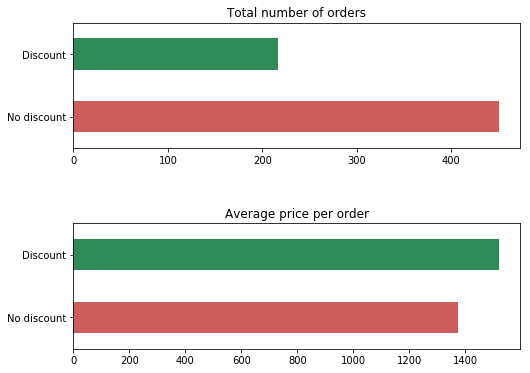

In [275]:
# Plotting the number of orders and average price per order for orders with and without discounts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df2.groupby(['Discount_bin'])['price_per_order'].count().plot(kind='barh', ax=ax1, color=['indianred', 'seagreen'])
df2.groupby(['Discount_bin'])['price_per_order'].mean().plot(kind='barh', ax=ax2, color=['indianred', 'seagreen'])
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax2.set_title('Average price per order')
ax1.set_yticklabels(['No discount', 'Discount'])
ax2.set_yticklabels(['No discount', 'Discount'])
fig.subplots_adjust(hspace=0.6);

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


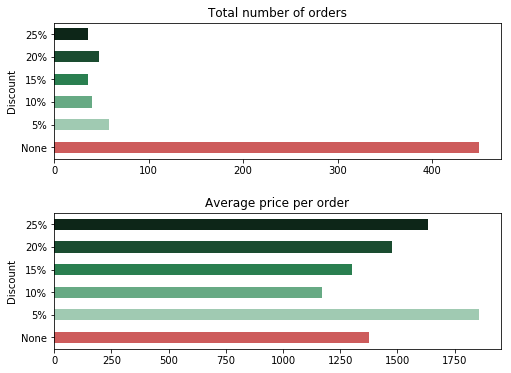

In [276]:
# Plotting the number of orders and average price per order for orders with different levels of discount
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df2.groupby(['Discount'])['price_per_order'].count().plot(kind='barh', ax=ax1, colors=['indianred', '#A0CAB2', '#67AA84', '#2A7F50', '#1A4C30', '#0D2618'])
df2.groupby(['Discount'])['price_per_order'].mean().plot(kind='barh', ax=ax2, colors=['indianred', '#A0CAB2', '#67AA84', '#2A7F50', '#1A4C30', '#0D2618'])
ax1.set_title('Total number of orders')
ax1.set_ylabel('Discount')
ax2.set_ylabel('Discount')
ax2.set_title('Average price per order')
ax1.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
ax2.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
fig.subplots_adjust(hspace=0.4);

In [277]:
# Average order prices for each discount level
round(df2.groupby(['Discount'])['price_per_order'].mean(),2)

Discount
0.00    1375.33
0.05    1857.73
0.10    1170.18
0.15    1300.85
0.20    1474.81
0.25    1634.30
Name: price_per_order, dtype: float64

In order to test whether there is a statistically significant difference between orders with and without a discount, a two-sample t-test will be used. This test assumes that the data is normally distributed, and that the samples have equal variances. This can be assessed with distribution plots:

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


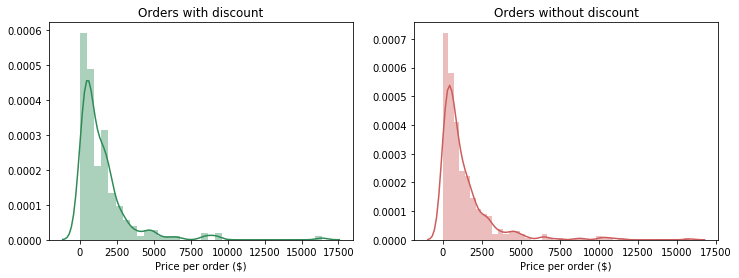

In [278]:
# Separating the dataset into orders with and without discounts, and assessing their distributions
discount = df2[df2['Discount_bin'] == 1]
no_discount = df2[df2['Discount_bin'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(discount.price_per_order, color='seagreen', ax=ax1)
sns.distplot(no_discount.price_per_order, color='indianred', ax=ax2)
plt.title('Distribution plots of the average price per order')
ax1.set_title('Orders with discount')
ax2.set_title('Orders without discount')
ax1.set_xlabel('Price per order ($)')
ax2.set_xlabel('Price per order ($)');

The distribution plots above show that the data is heavily positively skewed, with long tails. Log-transforming the data is likely to make it better fit the t-test assumptions.

In [280]:
# Copying the dataset and log-transforming price_per_order
df2_log = df2.copy()
df2_log['price_per_order'] = np.log(df2['price_per_order'])

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


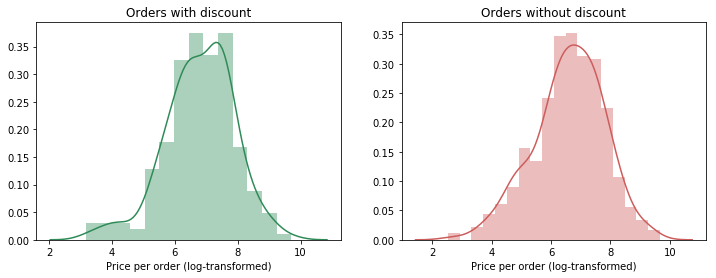

In [289]:
# Re-plotting the distributions for the log-transformed data
discount_log = df2_log[df2_log['Discount_bin'] == 1]
no_discount_log = df2_log[df2_log['Discount_bin'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(discount_log.price_per_order, color='seagreen', ax=ax1)
sns.distplot(no_discount_log.price_per_order, color='indianred', ax=ax2)
plt.title('Distribution plots of the average price per order')
ax1.set_title('Orders with discount')
ax2.set_title('Orders without discount')
ax1.set_xlabel('Price per order (log-transformed)')
ax2.set_xlabel('Price per order (log-transformed)');

The data is now more normally distributed.

In [287]:
# Running a two-sided t-test to compare two independent samples
stats.ttest_ind(discount_log.price_per_order, no_discount_log.price_per_order)

Ttest_indResult(statistic=2.025022744444036, pvalue=0.04326406148298754)

In [288]:
print("Average price per order for orders with no discounts: ", round(no_discount['price_per_order'].mean(),2))
print("Average price per order for orders with discounts: ", round(discount['price_per_order'].mean(),2))
print("Effect size: ", round(discount['price_per_order'].mean() - no_discount['price_per_order'].mean(),2))
print("Relative effect size (increase from no discount to discount): ", round(((discount['price_per_order'].mean() - no_discount['price_per_order'].mean())/no_discount['price_per_order'].mean())*100,1))

Average price per order for orders with no discounts:  1375.33
Average price per order for orders with discounts:  1518.6
Effect size:  143.27
Relative effect size (increase from no discount to discount):  10.4


The p-value is 0.043, which is less than the alpha value of 0.05. Therefore we can reject the null hypothesis and accept the alternative hypothesis. We can conclude that there is a statistically significant difference between the average price per order for orders with and without discounts.

 - **The average cost per order with no discount is \\$1,375.33, and the average cost per order with a discount is \\$1,518.60.**
 - **On average, customers spend $143.27 more on orders with discounts than without discounts, which is a 10% increase.**

**However, these correlations do not necessarily imply causation, and so it is not possible to categorically state that offering a discount will necessarily increase the amount that customers spend on an order by 10%.**

The second part of the question asks at what level of discount the statistically significant effect occurs. To answer this part of this question, a new null and alternate hypothesis need to be created:

**H<sub>0</sub>**: the average price per order is the same at different levels of discount

**H<sub>a</sub>**: the average price per order is different between the different levels of discount

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

To answer this question, ANOVA will be used in order to assess the degree of variation between multiple samples, where each sample is a different level of discount.

In [294]:
# Fitting a model of price_per_order on Discount categories, and using statsmodels to compute an ANOVA table
lm = ols('price_per_order ~ C(Discount)', discount_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),5.109529,4.0,1.055928,0.379379
Residual,256.461656,212.0,NaN,NaN


In [295]:
# Summary of the model and its coefficients
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_order   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.056
Date:                Fri, 08 Mar 2019   Prob (F-statistic):              0.379
Time:                        22:28:04   Log-Likelihood:                -326.04
No. Observations:                 217   AIC:                             662.1
Df Residuals:                     212   BIC:                             679.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.0426      0.144     48.764      0.000       6.758       7.327
C(Discount)[T.0.1]     -0.3656      0.226     -1.617      0.107      -0.811       0.080
C(Discount)[T.0.15]    -0.3598      0.233     -1.542      0.125      -0.820       0.100
C(Discount)[T.0.2]     -0.3528      0.216     -1.635      0.104      -0.778       0.073
C(Discount)[T.0.25]    -0.2731      0.233     -1.170      0.243      -0.733       0.187
==============================================================================
Omnibus:                        8.926   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.931
Skew:                          -0.437   Prob(JB):                       0.0115
Kurtosis:                       3.474   Cond. No.                         5.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [299]:
# Difference between the average price of orders with no discount and with different levels of discount
print("Average price per order for no discount: ", round((df2.loc[df2.Discount == 0]).price_per_order.mean(),2))
print("Average price per order for 5% discount: ", round((df2.loc[df2.Discount == 0.05]).price_per_order.mean(),2))
print("Absolute difference from no discount to 5% discount: ", float(round((df2.loc[df2.Discount == 0.05]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean(),2)))
print("Proportional difference from no discount to 5% discount: ", float(round(((df2.loc[df2.Discount == 0.05]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean()) / ((df2.loc[df2.Discount == 0]).price_per_order.mean()),2)))
print("Proportional difference from no discount to 10% discount: ", float(round(((df2.loc[df2.Discount == 0.10]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean()) / ((df2.loc[df2.Discount == 0]).price_per_order.mean()),2)))
print("Proportional difference from no discount to 15% discount: ", float(round(((df2.loc[df2.Discount == 0.15]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean()) / ((df2.loc[df2.Discount == 0]).price_per_order.mean()),2)))
print("Proportional difference from no discount to 20% discount: ", float(round(((df2.loc[df2.Discount == 0.20]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean()) / ((df2.loc[df2.Discount == 0]).price_per_order.mean()),2)))
print("Proportional difference from no discount to 25% discount: ", float(round(((df2.loc[df2.Discount == 0.25]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean()) / ((df2.loc[df2.Discount == 0]).price_per_order.mean()),2)))

Average price per order for no discount:  1375.33
Average price per order for 5% discount:  1857.73
Absolute difference from no discount to 5% discount:  482.4
Proportional difference from no discount to 5% discount:  0.35
Proportional difference from no discount to 10% discount:  -0.15
Proportional difference from no discount to 15% discount:  -0.05
Proportional difference from no discount to 20% discount:  0.07
Proportional difference from no discount to 25% discount:  0.19


The ANOVA table above reveals that the p-value is 0.379, which is above the alpha value of 0.05. Therefore we cannot reject the null hypothesis that **there are no significant differences in average order value between different discount levels**. 

The model summary also shows that there is no statistically significant difference between a discount level of 5% (applied to the whole order) and discount levels of 10%, 15%, 20% and 25%. Additionally, the overall r/eta squared value for the model is very low, implying that discount level only explains a very small amount of the variation in price per order.

### Conclusions

**Business insights:**
 - There are statistically significant differences in the average price per order for orders with and without discounts.
 - On average, customers spend $143.27 more on orders with discounts than without discounts, which is a 10% increase.
 - However, the differences in average price per order between different discount levels are not statistically significant.
 - Nevertheless, the discount level with the biggest effect size is 5%. The difference between the average price of orders with no discount (\\$1,375.33) and orders with a 5% discount (average price \\$1,857.73) is 35%. This is The only discount level that makes back more than it costs, i.e. results in an average price per order that is higher than the amount of the discount (when compared to the control group of no discount).
 - There are diminishing returns from offering higher levels of discount, although these differences are not statistically significant.
 - This analysis accords with the results of the answers to the previous question, that 5% is the optimum discount rate.
 
**Potential business actions and directions for future work:**

 - To increase revenue, one option worth considering would be to offer more 5% discounts, and fewer discounts of higher value.
 - However, further analysis would be needed to confirm that this is the best option, e.g. analysis of the different types of products that make up the different orders, what the existing levels of discount are that are offered on different products, and investigating what other factors influence the average price of an order.

***

## Question 3: Does the average amount spent per order vary between customers from different regions?

### Obtaining and scrubbing the data

In this query, we want to extract for each order the customer region, the total quantity of each product ordered, the unit price and the discount level (for calculating the actual price paid). To do this we need to join the Customer and OrderDetail tables using the Order table.

In [124]:
# Extracting the dataset for question 3 as a pandas dataframe
df3 = pd.read_sql_query("""SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
    FROM Customer c
    JOIN [Order] o ON c.Id = o.CustomerId
    JOIN OrderDetail od ON od.OrderId = o.Id
    """, engine)
df3.head()

2019-03-08 20:02:52,863 INFO sqlalchemy.engine.base.Engine SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
    FROM Customer c
    JOIN [Order] o ON c.Id = o.CustomerId
    JOIN OrderDetail od ON od.OrderId = o.Id
    
2019-03-08 20:02:52,864 INFO sqlalchemy.engine.base.Engine ()


,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [125]:
len(df3)

2078

In [126]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 5 columns):
Region       2078 non-null object
OrderId      2078 non-null int64
Quantity     2078 non-null int64
UnitPrice    2078 non-null float64
Discount     2078 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 81.2+ KB


There are no null values, so no need to replace any values.

An additional column will be added to calculate the actual price per order, by applying the discount to the product of the unit price and the unit quantity:

In [127]:
# Calculating the price per sub-order
df3['price_per_order'] = df3.Quantity * df3.UnitPrice * (1 - df3.Discount)

In [128]:
# Dropping the columns for quantity, unit price and discount now that we have the total price
df3.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

In [129]:
# Grouping the data by order and summing the price for each order
df3 = df3.groupby(['Region', 'OrderId'])['price_per_order'].sum().reset_index()
# Dropping the OrderId as we no longer need this
df3.drop('OrderId', axis=1, inplace=True)

In [130]:
df3.head()

,Region,price_per_order
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


In [131]:
len(df3)

801

### Exploring the data and answering the question

#### Does the average amount spent per order vary between customers from different regions?

To answer this question, a null and alternate hypothesis first need to be created:

**H<sub>0</sub>**: the average amount spent per order is the same between different customer regions

**H<sub>a</sub>**: the average amount spent per order is different (either higher or lower) between different customer regions

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

The table below shows the number of orders per region in the dataset:

In [132]:
df3.groupby('Region').count()

,price_per_order
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


Some regions only have a small number of orders, so it is worth combining them with other groups so that the groups are not of extremely unequal sizes (and therefore potentially also variances, which is relevant for the statistical tests that will be conducted later). A minimum group size of 30 will be used, so that t-tests can be used robustly.

In [133]:
# Combining Eastern and Southern Europe
df3.loc[(df3.Region == 'Eastern Europe') | (df3.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'
# Combining Scandinavia and Northern Europe
df3.loc[(df3.Region == 'Scandinavia') | (df3.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'
# Combining Central and South America
df3.loc[(df3.Region == 'Central America') | (df3.Region == 'South America'),'Region'] = 'South and Central America'

In [134]:
# Confirming no groups are smaller than 30
df3.groupby('Region').count()

,price_per_order
Region,
British Isles,75
North America,152
Northern Europe and Scandinavia,83
South and Central America,148
Southern and Eastern Europe,71
Western Europe,272


In [135]:
# Inspecting the summary statistics
df3.describe()

,price_per_order
count,801.000000
mean,1533.053014
std,1851.077071
min,12.500000
25%,458.755000
50%,954.400000
75%,1885.000000
max,16387.500000


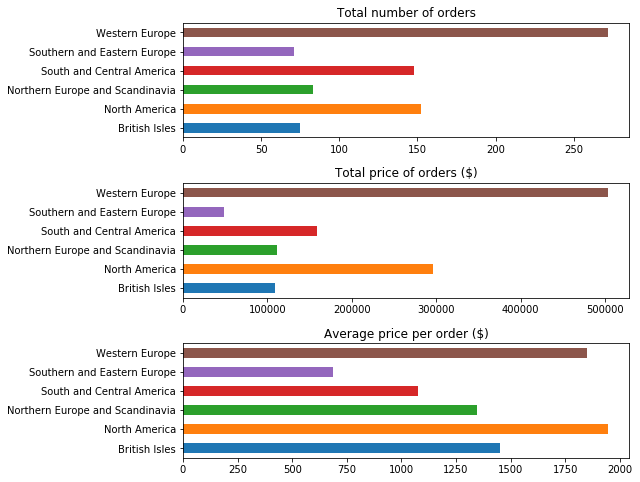

In [137]:
# Plotting the number of orders, total price per order and average price per order for each region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
df3.groupby(['Region'])['Region'].count().plot(kind='barh', ax=ax1)
df3.groupby(['Region'])['price_per_order'].sum().plot(kind='barh', ax=ax2)
df3.groupby(['Region'])['price_per_order'].mean().plot(kind='barh', ax=ax3)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Total price of orders ($)')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax3.set_title('Average price per order ($)')
fig.subplots_adjust(hspace=0.4);

In [139]:
# Total price of orders
round(df3.groupby(['Region'])['price_per_order'].sum(),2)

Region
British Isles                      108951.22
North America                      295780.90
Northern Europe and Scandinavia    111701.36
South and Central America          159235.91
Southern and Eastern Europe         48757.67
Western Europe                     503548.41
Name: price_per_order, dtype: float64

In [140]:
# Average price of orders
round(df3.groupby(['Region'])['price_per_order'].mean(),2)

Region
British Isles                      1452.68
North America                      1945.93
Northern Europe and Scandinavia    1345.80
South and Central America          1075.92
Southern and Eastern Europe         686.73
Western Europe                     1851.28
Name: price_per_order, dtype: float64

The graphs and tables above show that Western Europe is the region with the greatest number of orders, and also has the greatest total price of orders. However, North America has the most expensive order on average, followed by Western Europe. Southern and Eastern Europe has the lowest number of orders, lowest total price of orders, and cheapest order on average. The third graph lends support to the alternate hypothesis that there are significant differences in average order price between regions. This can be further investigated with statistical hypothesis testing.

In this case, ANOVA will be used to test whether the differences between multiple samples (each region) are statistically significant.

ANOVA assumes that the data is normally distributed, and that the samples have similar variances. This can be assessed with distribution plots:

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


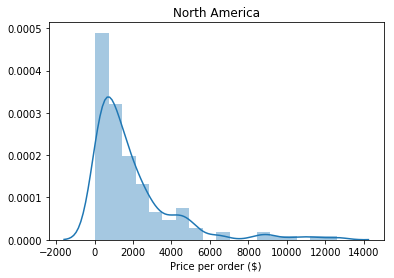

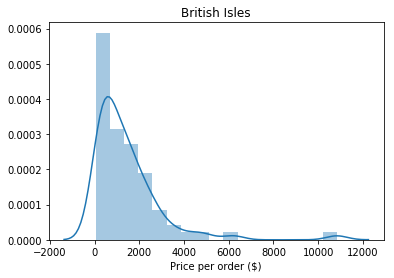

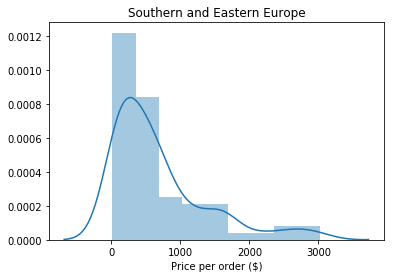

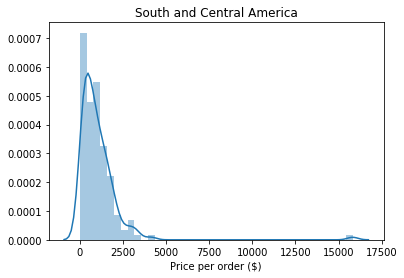

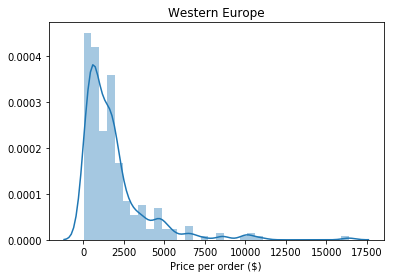

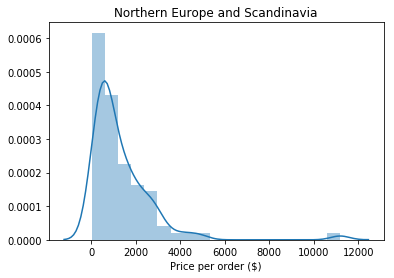

In [141]:
# Separating the dataset into orders from different regions, and assessing their distributions
for region in set(df3.Region):
    region_group = df3.loc[df3['Region'] == region]
    sns.distplot(region_group['price_per_order'])
    plt.title(region)
    plt.xlabel('Price per order ($)')
    plt.show()

The distribution plots above show that the data is heavily positively skewed, with very long tails (of different lengths for different regions). Although ANOVA is relatively robust to non-normal distributions, log-transforming the data is likely to make it better fit the ANOVA assumptions.

In [142]:
# Copying the dataset and log-transforming price_per_order
df3_log = df3.copy()
df3_log['price_per_order'] = np.log(df3['price_per_order'])

In [138]:
# Total number of orders
df3.groupby(['Region'])['Region'].count()

Region
British Isles                       75
North America                      152
Northern Europe and Scandinavia     83
South and Central America          148
Southern and Eastern Europe         71
Western Europe                     272
Name: Region, dtype: int64

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


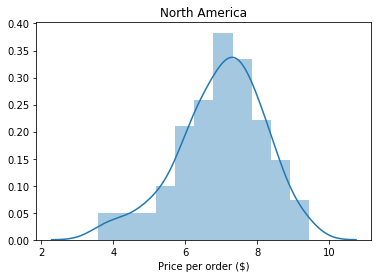

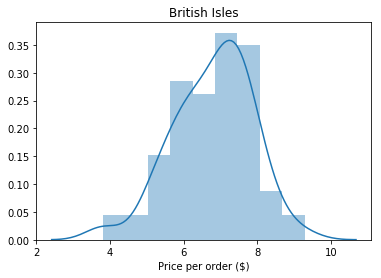

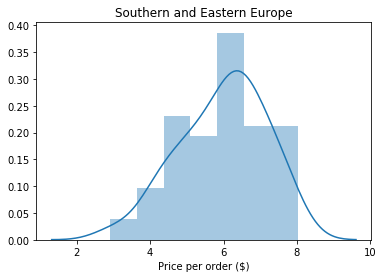

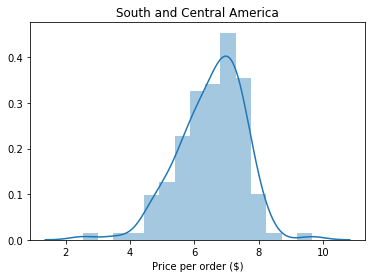

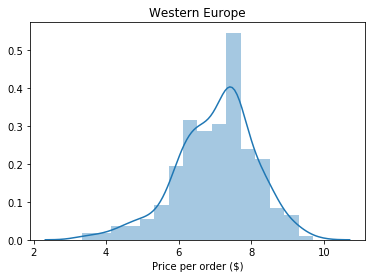

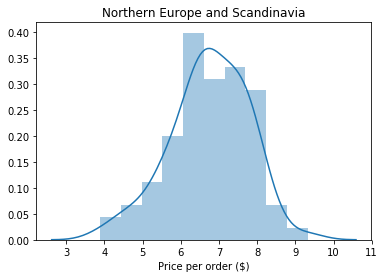

In [143]:
# Re-plotting the distributions for the log-transformed data
for region in set(df3_log.Region):
    region_group = df3_log.loc[df3_log['Region'] == region]
    sns.distplot(region_group['price_per_order'])
    plt.title(region)
    plt.xlabel('Price per order ($)')
    plt.show()

The data is now more normally distributed, and the variances from the mean are more similar. It is now possible to run an ANOVA test.

In [144]:
# Fitting a model of price_per_order on Region categories, and using statsmodels to compute an ANOVA table
lm = ols('price_per_order ~ C(Region)', df3_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Region),77.999547,5.0,13.032374,3.285724e-12
Residual,951.624641,795.0,NaN,NaN


In [145]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_order   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     13.03
Date:                Fri, 08 Mar 2019   Prob (F-statistic):           3.29e-12
Time:                        20:06:10   Log-Likelihood:                -1205.6
No. Observations:                 801   AIC:                             2423.
Df Residuals:                     795   BIC:                             2451.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        6.7904      0.126     53.750      0.000       6.542       7.038
C(Region)[T.North America]                       0.1968      0.154      1.274      0.203      -0.106       0.500
C(Region)[T.Northern Europe and Scandinavia]    -0.0461      0.174     -0.264      0.792      -0.388       0.296
C(Region)[T.South and Central America]          -0.2610      0.155     -1.683      0.093      -0.565       0.043
C(Region)[T.Southern and Eastern Europe]        -0.8159      0.181     -4.504      0.000      -1.171      -0.460
C(Region)[T.Western Europe]                      0.2322      0.143      1.627      0.104      -0.048       0.512
==============================================================================
Omnibus:                       37.987   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.797
Skew:                          -0.520   Prob(JB):                     5.09e-10
Kurtosis:                       3.449   Cond. No.                         9.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
# Difference between the average price of orders from Southern and Eastern European customers to those from North American customers
print("Absolute difference: ", float(round((df3.loc[df3.Region == 'North America']).mean() - (df3.loc[df3.Region == 'Southern and Eastern Europe']).mean(),2)))
print("Proportional difference: ", float(round(1 + ((df3.loc[df3.Region == 'North America']).mean() - (df3.loc[df3.Region == 'Southern and Eastern Europe']).mean()) / ((df3.loc[df3.Region == 'Southern and Eastern Europe']).mean()),2)))

Absolute difference:  1259.2
Proportional difference:  2.83


In [147]:
# Increase from the average price of orders from South and Central American customers to those from North American customers
1 + ((df3.loc[df3.Region == 'North America']).mean() - (df3.loc[df3.Region == 'South and Central America']).mean()) / ((df3.loc[df3.Region == 'South and Central America']).mean())

price_per_order    1.80862
dtype: float64

The ANOVA table above reveals that the p-value is  lower than the alpha value of 0.05. Therefore we can reject the null hypothesis and accept the alternate hypothesis. **We can conclude that there are significant differences in average order value between different regions, i.e. customers from different parts of the world spend different amounts of money on their orders, on average.**

### Conclusions

**Business insights:** 
 - There are statistically significant differences in the average price per order from customers from different regions.
 - Western Eurpean customers place the most orders, and are the single biggest contributors to Northwind's bottom line. However, although North American customers have placed roughly half as many orders as those from Western Europe, they spend more per order, on average.
 - The difference between the region with the most expensive orders on average (North America, \\$1,945.93) and the region with the least expensive orders (Southern and Eastern Europe, \\$686.73) is \\$1,259.20, or 2.8 times more.
 - Southern and Eastern Europe has the smallest number of orders, the lowest total price of orders, and the lowest average price per order.
 - North American customers have placed a similar number of orders to those from South and Central America, but their average expenditure per order is 1.8 times higher.


**Potential business actions and directions for future work:**

 - If Northwind was looking to focus on more profitable customers, a potential action would be to stop serving customers in Southern and Eastern Europe, and to focus more on customers in Western Europe and North America.
 
 - However, further analysis would be needed to confirm these findings (for example, it might be the case that some more expensive products are only available in certain regions).

***

## Question 4: Do customers order more products on particular days of the week?

### Obtaining and scrubbing the data

In this query, we want to extract the date that each order was placed on and the number of items ordered, from the Order and OrderDetail tables.

In [150]:
df3.loc[df3.Region == 'Southern and Eastern Europe'].mean()

price_per_order    686.727711
dtype: float64

In [151]:
# Extracting the dataset for question 4 as a pandas dataframe
df4 = pd.read_sql_query("""SELECT o.OrderDate, od.Quantity
    FROM [Order] o
    JOIN OrderDetail od ON od.OrderId = o.Id
    """, engine)
df4.head()

2019-03-08 20:13:37,751 INFO sqlalchemy.engine.base.Engine SELECT o.OrderDate, od.Quantity
    FROM [Order] o
    JOIN OrderDetail od ON od.OrderId = o.Id
    
2019-03-08 20:13:37,752 INFO sqlalchemy.engine.base.Engine ()


,OrderDate,Quantity
0,2012-07-04,12
1,2012-07-04,10
2,2012-07-04,5
3,2012-07-05,9
4,2012-07-05,40


In [154]:
len(df4)

2155

In [155]:
# Checking for null values - none found
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 2 columns):
OrderDate    2155 non-null object
Quantity     2155 non-null int64
dtypes: int64(1), object(1)
memory usage: 33.8+ KB


OrderDate now needs to be converted from a full date to the day of the week.

In [156]:
# Converting to datetime
df4['OrderDate'] = pd.to_datetime(df4['OrderDate'])
# Adding a column for the day of the week
df4['day_of_week'] = df4['OrderDate'].dt.weekday_name
# Adding a column for the number of the day of the week (to help with visualising in the correct order)
df4['int_day_of_week'] = df4['OrderDate'].dt.dayofweek

In [157]:
df4.head()

,OrderDate,Quantity,day_of_week,int_day_of_week
0,2012-07-04,12,Wednesday,2
1,2012-07-04,10,Wednesday,2
2,2012-07-04,5,Wednesday,2
3,2012-07-05,9,Thursday,3
4,2012-07-05,40,Thursday,3


### Exploring the data and answering the question

#### Do customers order more products on particular days of the week?

To answer this question, a null and alternate hypothesis first need to be created:

**H<sub>0</sub>**: the average number of products ordered on each day of the week is the same for each day

**H<sub>a</sub>**: the average number of products ordered on each day of the week is different (either higher or lower) for each day

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

In [158]:
# Investigating date range
print(f"The dates range from {df4.OrderDate.min().date()} to {df4.OrderDate.max().date()}")

The dates range from 2012-07-04 to 2014-05-06


The graph below plots the number of orders in each dataset over the period that the graph covers. It shows a general upwards trend with the number of orders increasing over time, particularly in 2014.

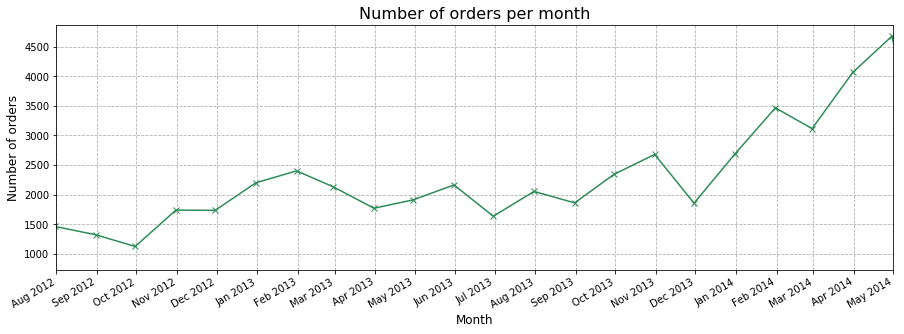

In [159]:
# Plotting the number of orders per month
per_month = df4.set_index('OrderDate').groupby(pd.Grouper(freq='M'))['Quantity'].sum()

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(per_month.index, per_month.values, marker='x', color='seagreen')
ax.set_title('Number of orders per month', size=16)
ax.set_xlabel('Month', size=12)
ax.set_ylabel('Number of orders', size=12)
ax.grid(linestyle='--')
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_xlim(left='2012-08-01', right='2014-05-01') # Removing the incomplete months at the beginning and end
fig.autofmt_xdate();

Orders are only placed on Sundays to Thursdays. The graphs below show that there are similar numbers of orders placed on each day of the week, and similar numbers of items ordered. Whether or not the differences that do exist are statistically signicant will be tested below, using ANOVA.

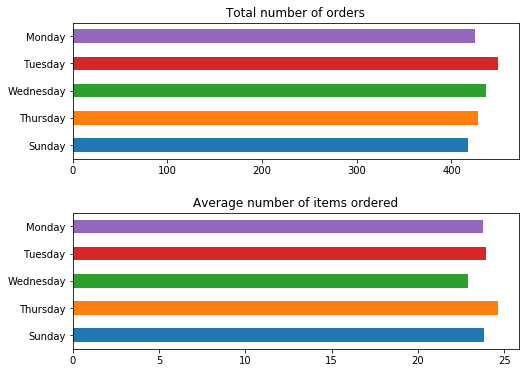

In [160]:
# Plotting the number of items ordered by the day of the week
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df4.sort_values(['int_day_of_week'], ascending=False).groupby(['day_of_week'], sort=False)['day_of_week'].count().plot(kind='barh', ax=ax1)
df4.sort_values(['int_day_of_week'], ascending=False).groupby(['day_of_week'], sort=False)['Quantity'].mean().plot(kind='barh', ax=ax2)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Average number of items ordered')
ax2.set_ylabel('')
fig.subplots_adjust(hspace=0.4);

ANOVA assumes that the data is normally distributed, and that the samples have similar variances. This can be assessed with distribution plots:

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


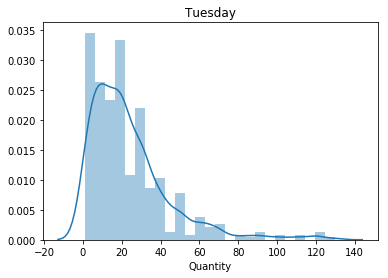

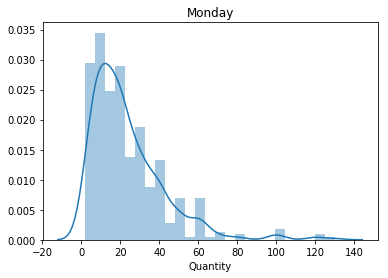

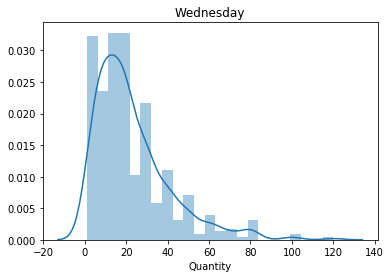

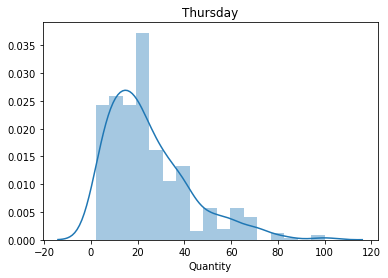

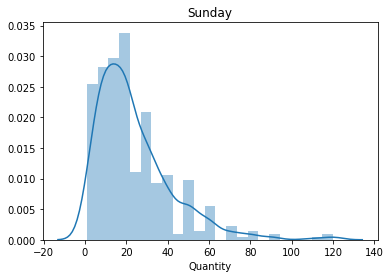

In [161]:
# Separating the dataset into orders from different days of the week, and assessing their distributions
for day in set(df4['day_of_week']):
    day_group = df4.loc[df4['day_of_week'] == day]
    sns.distplot(day_group['Quantity'])
    plt.title(day)
    plt.show()

Although the data is positively skewed, the distributions are similar enough to each other and to a normal distribution to allow an ANOVA test to be conducted.

In [162]:
# Fitting a model of price_per_order on Region categories, and using statsmodels to compute an ANOVA table
lm = ols('Quantity ~ C(day_of_week)', df4).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(day_of_week),662.192111,4.0,0.457058,0.7673
Residual,778737.444084,2150.0,NaN,NaN


In [163]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4571
Date:                Fri, 08 Mar 2019   Prob (F-statistic):              0.767
Time:                        20:15:33   Log-Likelihood:                -9404.2
No. Observations:                2155   AIC:                         1.882e+04
Df Residuals:                    2150   BIC:                         1.885e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      23.7553      0.923     25.732      0.000      21.945      25.566
C(day_of_week)[T.Sunday]        0.0768      1.312      0.059      0.953      -2.496       2.649
C(day_of_week)[T.Thursday]      0.8732      1.303      0.670      0.503      -1.683       3.429
C(day_of_week)[T.Tuesday]       0.2068      1.288      0.161      0.872      -2.319       2.733
C(day_of_week)[T.Wednesday]    -0.8585      1.297     -0.662      0.508      -3.403       1.686
==============================================================================
Omnibus:                      790.296   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3047.217
Skew:                           1.784   Prob(JB):                         0.00
Kurtosis:                       7.606   Cond. No.                         5.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The ANOVA table above reveals that the p-value is 0.767, which is much higher than the alpha value of 0.05. Therefore we cannot reject the null hypothesis that there is no difference between the average number of items ordered on each day of the week. The model summary table provides further evidence for this conclusion. The p-values for each pairwise comparison between Monday and every other day are all above the alpha value, indicating that no individual days have a statistically significant difference. Additionally, the overall r/eta squared value for the model is negligible, confirming that the day on which an order was placed does not explain the differences in the numbers of items ordered.

### Conclusions

**Business insights:**
 - There are no statistically significant differences in the number of items ordered on different days of the week

**Potential business actions and directions for future work:**
 - If customers are ordering similar numbers of items on each day of the week, it suggests that there is no need to staff different days with different numbers of sales representatives or make other adjustments. However, further work could be conducted to investigate other potential differences between days, e.g. more or less expensive items ordered on different days of the week.

***

## Summary

Four questions were addressed over the course of this project:

1. *Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?*
 - **Yes**. The presence of a discount has a statistically significant effect on the number of products customers order, with a **26% increase** in the number of items ordered for products with a discount offered compared to those with no discount. However, there are no statistically significant differences between different levels of discount. Results therefore suggest that the optimum level of discount is 5% (the lowest offered).


2. *Do discounts affect the amount that a customer spends on their order? If so, at what level(s) of discount, and does offering discounts make back more than they cost?*
 - **Yes**. The presence of a discount has a statistically significant effect on the amount that customers spend per order, with a **10% increase** in the average price per order for orders with a discount offered, compared to those with no discount. However, there are no statistically significant differences between different levels of discount. Results therefore suggest that the optimum level of discount is 5% (the only discoutn level that makes back more than it costs).
 
3. *Does the average amount spent per order vary between customers from different regions?*
 - **Yes**. There are statistically significant differences in the average price per order from customers from different regions. Western Eurpean customers place the most orders, and are the single biggest contributors to Northwind's bottom line, but North American customers places the most expensive orders on average. Southern and Eastern Europe has the smallest number of orders, the lowest total price of orders, and the lowest average price per order. North American customers spend **2.8 times more** per order than Southern and Eastern European customers.


4. *Do customers order more products on particular days of the week?*
 - **No**. There are no statistically significant differences between the number of products ordered on different days of the week.